#Detection of objects in a frame extracted from a video

YOLOv3 (You Only Look Once, Version 3) is a real-time object detection algorithm that identifies specific objects in videos, live feeds, or images. YOLO uses features learned by a deep convolutional neural network to detect an object. Versions 1-3 of YOLO were created by Joseph Redmon and Ali Farhadi.


#Building Darknet for YOLOv3

Darknet is an open source neural network framework written in C and CUDA. It is fast, easy to install, and supports CPU and GPU computation.

In [1]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15395, done.
remote: Total 15395 (delta 0), reused 0 (delta 0), pack-reused 15395
Receiving objects: 100% (15395/15395), 14.02 MiB | 25.05 MiB/s, done.
Resolving deltas: 100% (10352/10352), done.


In [2]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [3]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [4]:
# make darknet (build)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

#Downloading pretrained YOLOv3 Weights

YOLOv3 has been trained already on the coco dataset which has 80 classes that it can predict. We will grab these pretrained weights so that we can run YOLOv3 on these pretrained classes and get detections.

In [5]:
# get yolov3 pretrained coco dataset weights
!wget https://pjreddie.com/media/files/yolov3.weights

--2022-01-29 13:44:26--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  46.4MB/s    in 5.4s    

2022-01-29 13:44:31 (43.5 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [6]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

#Testing the YOLO detections

In [16]:
# run darknet detection
!./darknet detect cfg/yolov3.cfg yolov3.weights data/person.jpg

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  

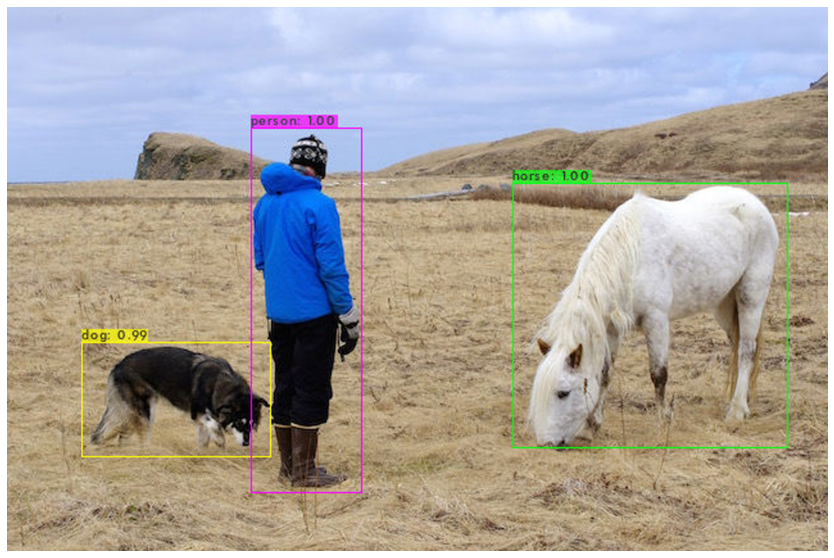

In [17]:
# show image using our helper function
imShow('predictions.jpg')

In [13]:
# upload an image to root directory (I uploaded an image called street.jpg, you can upload anything)
%cd /content
upload()

/content


Saving CaptureOfficePeople.JPG to CaptureOfficePeople.JPG
saved file CaptureOfficePeople.JPG


In [20]:
# make sure you are in the darknet folder to run the detections command!
%cd /content/darknet
!./darknet detect cfg/yolov3.cfg yolov3.weights /content/CaptureOfficePeople.JPG

/content/darknet
 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Sho

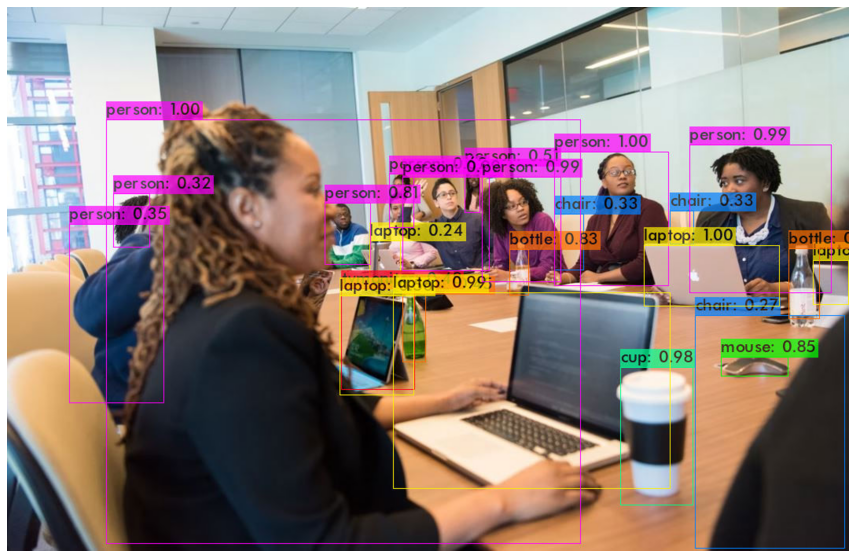

In [21]:
# show image using our helper function
imShow('predictions.jpg')

#Working with Video 

The code will take input video and extract a frame. The name of video file should be the timestamp of the frame you want to extract.
Example: if you want a frame at 1.92, then name your video file as 1.92

In [22]:
import sys
import numpy as np
import cv2
import moviepy.editor as mpy
from matplotlib import pyplot as plt

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)4014080/45929032 bytes (8.7%)8208384/45929032 bytes (17.9%)12263424/45929032 bytes (26.7%)16220160/45929032 bytes (35.3%)20258816/45929032 bytes (44.1%)24264704/45929032 bytes (52.8%)27934720/45929032 bytes (60.8%)31866880/45929032 bytes (69.4%)36036608/45929032 bytes (78.5%)40148992/45929032 bytes (87.4%)44163072/45929032 bytes (96.2%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

1) Getting input video file and extracting frame

Saving 1.92.mp4 to 1.92 (1).mp4
saved file 1.92.mp4
1.92
1.92


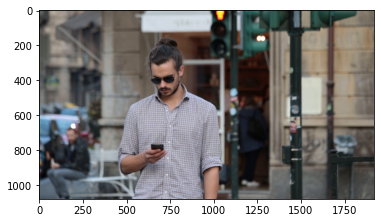

In [32]:
from google.colab import files
uploaded = files.upload() 
for name, data in uploaded.items():
  with open(name, 'wb') as f:
    f.write(data)
    print ('saved file', name)
vid = mpy.VideoFileClip(name)
timestamp=name.strip(".mp4")  
print(timestamp)
for i, (tstamp, frame) in enumerate(vid.iter_frames(with_times=True)):
    if str(tstamp)==timestamp:
        print(tstamp%60)
        plt.imshow(frame)
        plt.show()
        cv2.imwrite("/content/vid1.jpg",frame)

/content/darknet
 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Sho

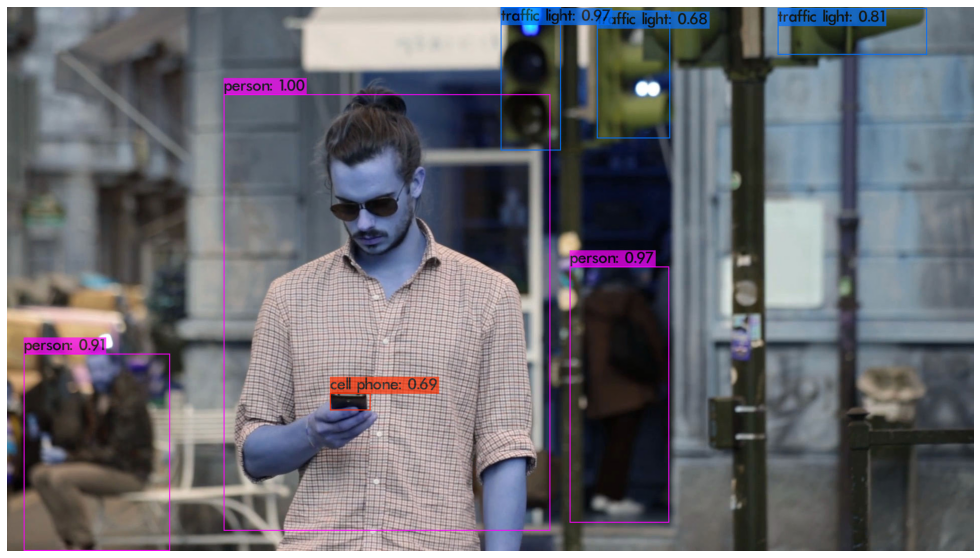

In [26]:
%cd /content/darknet
!./darknet detect cfg/yolov3.cfg yolov3.weights /content/vid1.jpg
# show image using our helper function
imShow('predictions.jpg')

2) Getting input video file and extracting frame

Saving 3.128125.mp4 to 3.128125.mp4
saved file 3.128125.mp4
3.128125


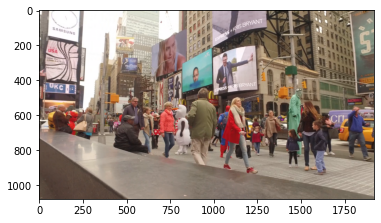

In [33]:
from google.colab import files
uploaded = files.upload() 
for name, data in uploaded.items():
  with open(name, 'wb') as f:
    f.write(data)
    print ('saved file', name)
vid = mpy.VideoFileClip(name)
timestamp=name.strip(".mp4") 
for i, (tstamp, frame) in enumerate(vid.iter_frames(with_times=True)):
    if str(tstamp)==timestamp:
        print(tstamp%60)
        plt.imshow(frame)
        plt.show()
        cv2.imwrite("/content/vid2.jpg",frame)

/content/darknet
 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Sho

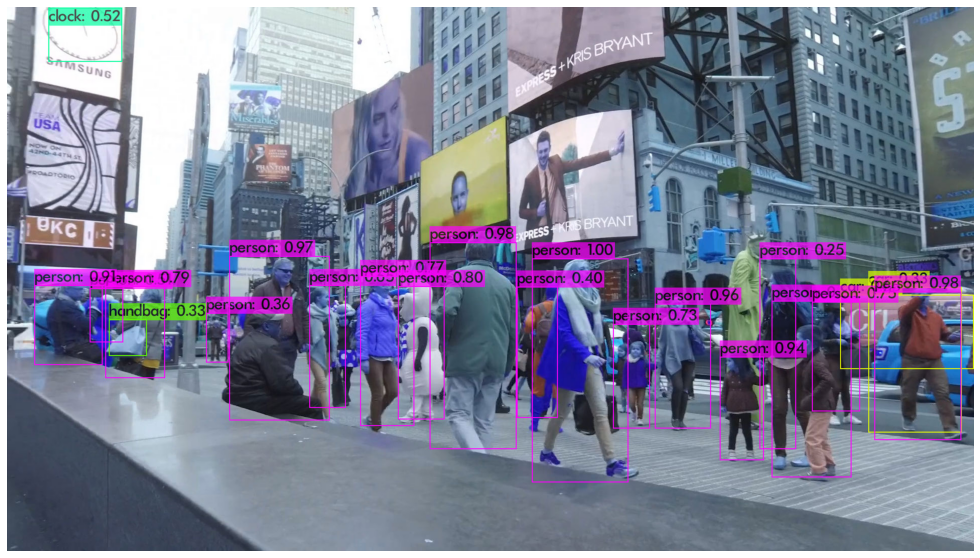

In [27]:
%cd /content/darknet
!./darknet detect cfg/yolov3.cfg yolov3.weights /content/vid2.jpg
# show image using our helper function
imShow('predictions.jpg')